In [1]:
using Dates
using Loess
using Plots
using QuadGK

In [2]:
davis_county = [
    (Date(2020, 3, 15), 3),
    (Date(2020, 3, 16), 3),
    (Date(2020, 3, 17), 4),
    (Date(2020, 3, 18), 4),
    (Date(2020, 3, 19), 6),
    (Date(2020, 3, 20), 12),
    (Date(2020, 3, 21), 14),
    (Date(2020, 3, 22), 19),
    (Date(2020, 3, 23), 29),
    (Date(2020, 3, 24), 31),
    
    (Date(2020, 4, 3), 122, 10),
    (Date(2020, 4, 4), 137, 10),
    (Date(2020, 4, 5), 142, 10),
    (Date(2020, 4, 6), 154, 11),
    (Date(2020, 4, 7), 158, 12),
    
    (Date(2020, 4, 9), 170, 15),
    (Date(2020, 4, 10), 180, 15),
    (Date(2020, 4, 11), 193, 17),
    (Date(2020, 4, 12), 199, 20),
    (Date(2020, 4, 13), 204, 21),
    (Date(2020, 4, 14), 211, 21),
    (Date(2020, 4, 15), 217, 21),
    (Date(2020, 4, 16), 220, 21, 2),
    (Date(2020, 4, 17), 227, 21, 2),
    (Date(2020, 4, 18), 230, 21, 2),
    (Date(2020, 4, 19), 236, 21, 2),
    (Date(2020, 4, 20), 242, 21, 2),
    (Date(2020, 4, 21), 243, 21, 2),
    (Date(2020, 4, 22), 249, 21, 2),
    (Date(2020, 4, 23), 254, 21, 2),
    (Date(2020, 4, 24), 256, 21, 2),
    (Date(2020, 4, 25), 268, 21, 2),
    (Date(2020, 4, 26), 275, 22, 2),
    (Date(2020, 4, 27), 276, 23, 2),
    
    (Date(2020, 4, 29), 283, 23, 2),
    (Date(2020, 4, 30), 285, 23, 2),
    
    (Date(2020, 5, 1), 293, 23, 2),
    (Date(2020, 5, 2), 296, 23, 2),
    (Date(2020, 5, 3), 300, 23, 2),
    (Date(2020, 5, 4), 299, 24, 2),
    (Date(2020, 5, 5), 302, 25, 2),
    (Date(2020, 5, 6), 308, 26, 2),
    (Date(2020, 5, 7), 315, 26, 2),
    (Date(2020, 5, 8), 321, 27, 2),
    (Date(2020, 5, 9), 327, 27, 2),
    (Date(2020, 5, 10), 336, 28, 2),
    (Date(2020, 5, 11), 338, 28, 2),
    (Date(2020, 5, 12), 340, 28, 2),
    (Date(2020, 5, 13), 344, 29, 2),
    (Date(2020, 5, 14), 349, 28, 2),
    (Date(2020, 5, 15), 354, 28, 2),
    (Date(2020, 5, 16), 363, 29, 2),
    (Date(2020, 5, 17), 368, 31, 2),
    (Date(2020, 5, 18), 370, 32, 2),

    (Date(2020, 5, 20), 386, 32, 2),
    (Date(2020, 5, 21), 396, 34, 2),
    (Date(2020, 5, 22), 401, 34, 2),
    (Date(2020, 5, 23), 407, 34, 2),
    (Date(2020, 5, 24), 410, 36, 2),
    (Date(2020, 5, 25), 414, 36, 2),
    (Date(2020, 5, 26), 419, 37, 2),
    (Date(2020, 5, 27), 424, 38, 2),
    (Date(2020, 5, 28), 435, 38, 2),
    (Date(2020, 5, 29), 447, 41, 2),
    (Date(2020, 5, 30), 458, 41, 2),
    (Date(2020, 5, 31), 465, 41, 2),
    
    (Date(2020, 6, 1), 472, 42, 2),
    (Date(2020, 6, 2), 476, 42, 2),
    (Date(2020, 6, 3), 494, 47, 2),
    (Date(2020, 6, 4), 513, 48, 2),
    (Date(2020, 6, 5), 525, 49, 2),
    (Date(2020, 6, 6), 541, 49, 2),
    (Date(2020, 6, 7), 549, 50, 2),
    (Date(2020, 6, 8), 564, 52, 3),
    (Date(2020, 6, 9), 580, 53, 3),
    (Date(2020, 6, 10), 593, 53, 4),
    (Date(2020, 6, 11), 620, 53, 4),
    (Date(2020, 6, 12), 628, 53, 4),
    (Date(2020, 6, 13), 646, 55, 4),
    (Date(2020, 6, 14), 660, 56, 4),
    (Date(2020, 6, 15), 672, 57, 4),
    (Date(2020, 6, 16), 691, 61, 4),
    (Date(2020, 6, 17), 715, 63, 4),
    (Date(2020, 6, 18), 739, 59, 4),
    (Date(2020, 6, 19), 775, 58, 4),
    (Date(2020, 6, 20), 822, 59, 4),
    (Date(2020, 6, 21), 856, 61, 4),
    (Date(2020, 6, 22), 877, 61, 4),
    (Date(2020, 6, 23), 905, 62, 4),
    (Date(2020, 6, 24), 938, 62, 4),
    (Date(2020, 6, 25), 989, 65, 4),
    (Date(2020, 6, 26), 1036, 70, 4),
    (Date(2020, 6, 27), 1080, 75, 4),
]

93-element Array{Tuple{Date,Int64,Vararg{Int64,N} where N},1}:
 (2020-03-15, 3)
 (2020-03-16, 3)
 (2020-03-17, 4)
 (2020-03-18, 4)
 (2020-03-19, 6)
 (2020-03-20, 12)
 (2020-03-21, 14)
 (2020-03-22, 19)
 (2020-03-23, 19)
 (2020-03-24, 31)
 (2020-04-03, 122, 10)
 (2020-04-04, 137, 10)
 (2020-04-05, 142, 10)
 ⋮
 (2020-06-16, 691, 61, 4)
 (2020-06-17, 715, 63, 4)
 (2020-06-18, 739, 59, 4)
 (2020-06-19, 775, 58, 4)
 (2020-06-20, 822, 59, 4)
 (2020-06-21, 856, 61, 4)
 (2020-06-22, 877, 61, 4)
 (2020-06-23, 905, 62, 4)
 (2020-06-24, 938, 62, 4)
 (2020-06-25, 989, 65, 4)
 (2020-06-26, 1036, 70, 4)
 (2020-06-27, 1080, 75, 4)

In [3]:
cumulative = [(i[1], i[2]) for i in davis_county]

93-element Array{Tuple{Date,Int64},1}:
 (2020-03-15, 3)
 (2020-03-16, 3)
 (2020-03-17, 4)
 (2020-03-18, 4)
 (2020-03-19, 6)
 (2020-03-20, 12)
 (2020-03-21, 14)
 (2020-03-22, 19)
 (2020-03-23, 19)
 (2020-03-24, 31)
 (2020-04-03, 122)
 (2020-04-04, 137)
 (2020-04-05, 142)
 ⋮
 (2020-06-16, 691)
 (2020-06-17, 715)
 (2020-06-18, 739)
 (2020-06-19, 775)
 (2020-06-20, 822)
 (2020-06-21, 856)
 (2020-06-22, 877)
 (2020-06-23, 905)
 (2020-06-24, 938)
 (2020-06-25, 989)
 (2020-06-26, 1036)
 (2020-06-27, 1080)

In [4]:
daily_change = Tuple{Float64,Float64}[]
for i in 1:length(davis_county)
    if i == 1
        push!(daily_change, (0, davis_county[i][2]))
    else
        case_delta = davis_county[i][2] - davis_county[i-1][2]
        time_delta = (davis_county[i][1] - davis_county[i-1][1]).value
        day = (davis_county[i][1] - davis_county[1][1]).value
        push!(daily_change, (day, case_delta / time_delta))
    end
end
daily_change

93-element Array{Tuple{Float64,Float64},1}:
 (0.0, 3.0)
 (1.0, 0.0)
 (2.0, 1.0)
 (3.0, 0.0)
 (4.0, 2.0)
 (5.0, 6.0)
 (6.0, 2.0)
 (7.0, 5.0)
 (8.0, 0.0)
 (9.0, 12.0)
 (19.0, 9.1)
 (20.0, 15.0)
 (21.0, 5.0)
 ⋮
 (93.0, 19.0)
 (94.0, 24.0)
 (95.0, 24.0)
 (96.0, 36.0)
 (97.0, 47.0)
 (98.0, 34.0)
 (99.0, 21.0)
 (100.0, 28.0)
 (101.0, 33.0)
 (102.0, 51.0)
 (103.0, 47.0)
 (104.0, 44.0)

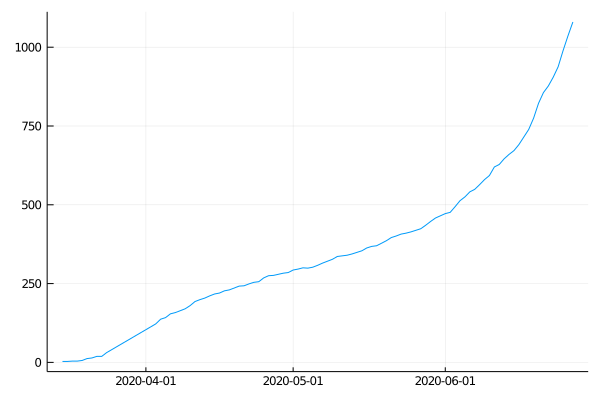

In [5]:
plot(cumulative, legend=false)

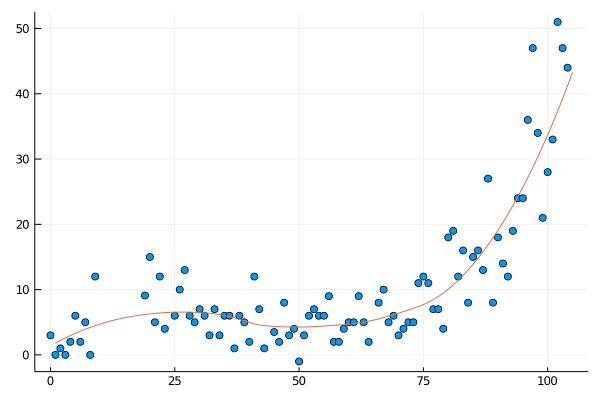

In [6]:
daily_change_model = loess([i[1] for i in daily_change], [i[2] for i in daily_change])
scatter(daily_change, legend=false)
start, stop = extrema([i[1] for i in daily_change])
plot!(predict(daily_change_model, start:stop))

In [7]:
davis_county_population = 356_000
current_daily_growth = predict(daily_change_model, [stop])[1]
println(current_daily_growth)
println(davis_county_population / current_daily_growth / 365)

43.28732888701862
22.53182376531251


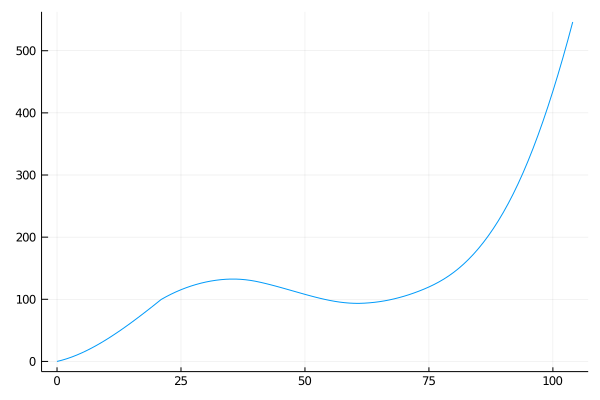

In [8]:
f(x) = x < 0 ? 0 : predict(daily_change_model, [x])[1]
active_cases(x) = quadgk(f, x-21, x)[1]
plot(start:stop, active_cases, legend=false)

In [9]:
active_cases(stop)

546.246354809978